In [11]:
# default_exp viral

# Inspect viral infection progression

We do this based on MCP and psbA expression derived from channels 4 (TMR) and 11 (Cy5)

In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# %load common.py
# export

import pandas
import os
import numpy
import seaborn
import logging
import matplotlib.pyplot as plt
from matplotlib import cm
from importlib import reload
from ehv import core
from joblib import load, dump
from pathlib import Path
import uuid

plt.rcParams['figure.facecolor'] = 'white'

numpy.random.seed(42)

In [37]:
# export
from ehv import load as e_load
from pathlib import Path
import flowkit
import re

In [54]:
samples = None
df = e_load.load_raw_ideas_dir(
    Path("/data/weizmann/EhV/high_time_res"), 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), 
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"),
    samples, "Low/*.cif")
df = e_load.remove_unwanted_features(df)
df = e_load.tag_columns(df)
df = e_load.clean_column_names(df)

df = df[df["meta_label_coi"]]

reg = r"^meta_label_(.+)$"
label_vec = numpy.full((df.shape[0]), fill_value="unknown", dtype=object)
for col in df.filter(regex="(?i)meta_label_.*psba.*"):
    label_vec[df[col].values] = re.match(reg, col).groups(1)
    
df["meta_label"] = label_vec

df = df.reset_index(drop=True)

In [55]:
df.shape

(339045, 114)

# MCP versus PSBA markers

In [81]:
# export

def get_logicle_xform(series):
    M = 4.5
    T = max(series)
    r = series[series < 0].quantile(0.05)
    if r == numpy.nan:
        r = 1
    
    if T > 0:
        W = (M - numpy.log(T/abs(r)))/2
    else:
        W = 1.5
        
    print(M, T, r, W)
        
    return flowkit.transforms.LogicleTransform('logicle', param_t=T, param_w=W, param_m=M, param_a=0)

def logicle_transform(df):
    samples = []
    for (t_idx, r_idx), gdf in df.groupby(["meta_timepoint", "meta_replicate"]):
        xform = get_logicle_xform(df["feat_intensity_mc_ch7"])
        sample = flowkit.Sample(gdf[["feat_intensity_mc_ch04", "feat_intensity_mc_ch11", "feat_intensity_mc_ch7"]])
        sample.apply_transform(xform)
        sample_df = sample.as_dataframe(source="xform").set_index(gdf.index)
        sample_df.columns = [col+"_logicle" for col in sample_df.columns.get_level_values(0)]
        samples.append(sample_df)

    return pandas.concat(samples)

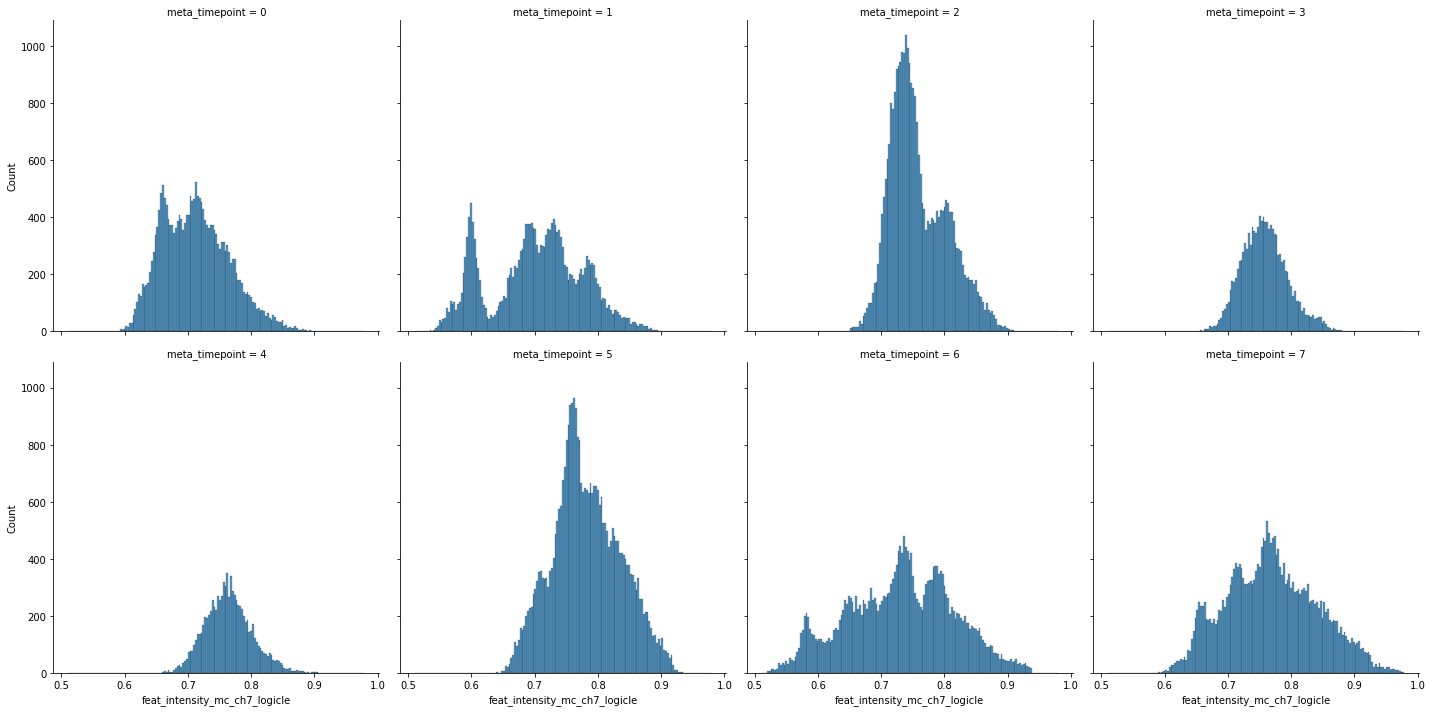

In [76]:
seaborn.displot(data=df[df["meta_timepoint"] < 8], x="feat_intensity_mc_ch7_logicle", col="meta_timepoint", col_wrap=4)

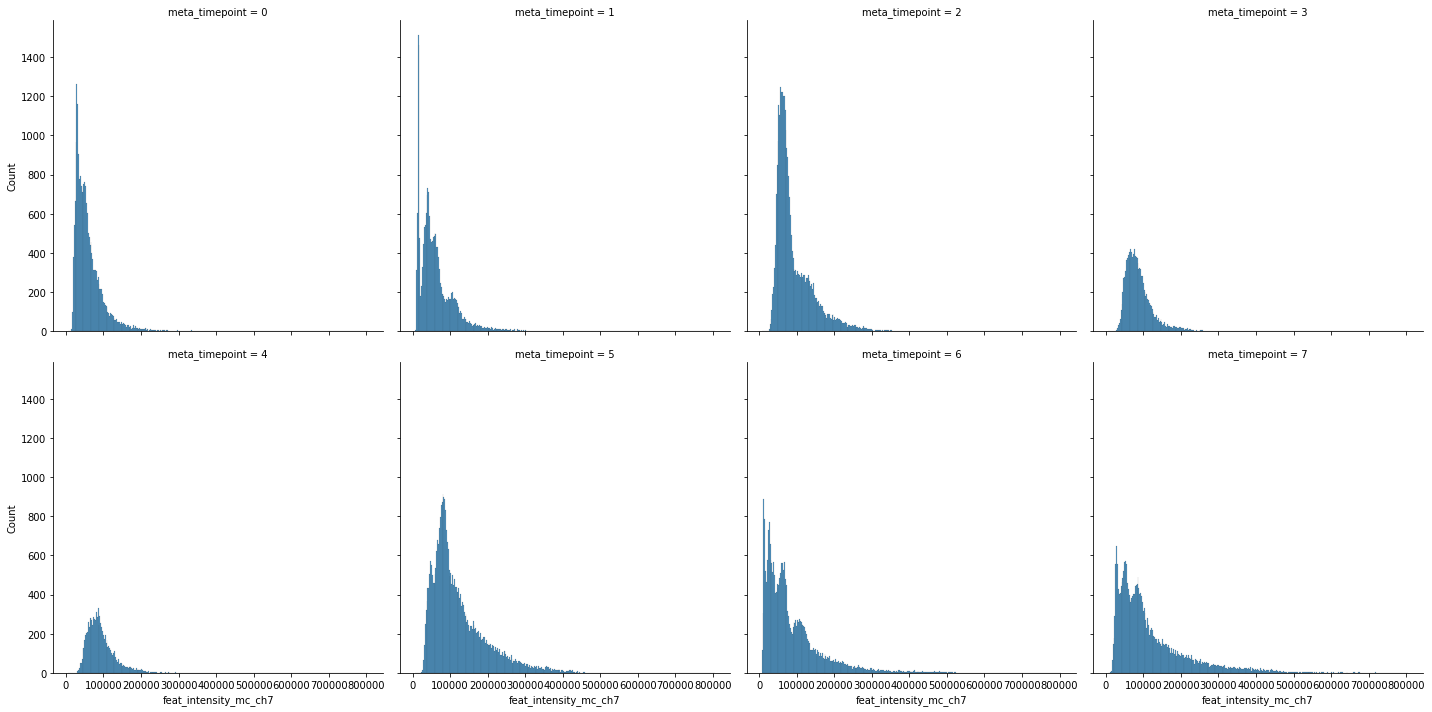

In [73]:
seaborn.displot(data=df[df["meta_timepoint"] < 8], x="feat_intensity_mc_ch7", col="meta_timepoint", col_wrap=4)

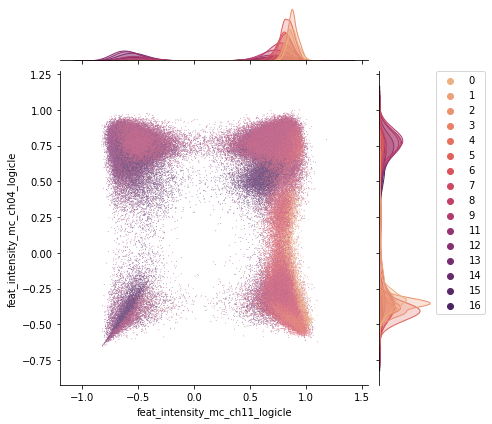

In [58]:
tmp_df = df
fig = seaborn.jointplot(
    data=tmp_df, y="feat_intensity_mc_ch04_logicle", x="feat_intensity_mc_ch11_logicle", 
    hue="meta_timepoint", hue_order=sorted(tmp_df["meta_timepoint"].unique()), 
    s=0.5, palette="flare", legend="full")
fig.ax_joint.legend(bbox_to_anchor=(1.22, 1), loc=2, borderaxespad=0.)
# fig.ax_joint.axis("off")
# plt.savefig("figs/features/HTR_High_viral_progression.png", dpi=300, transparent=True, bbox_inches = "tight")

# Infected cells per timepoint

<AxesSubplot:xlabel='meta_timepoint', ylabel='count'>

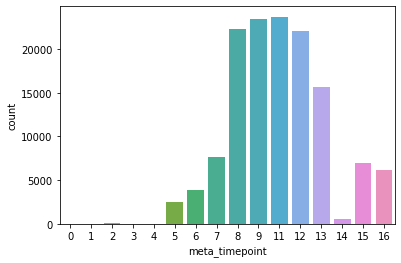

In [35]:
seaborn.countplot(data=df[df["meta_label_mcp_pos_psba_neg"] | df["meta_label_mcp_pos_psba_pos"]], x="meta_timepoint")